In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [25]:
from sympy import Derivative, S, Symbol, series, sqrt, symbols, oo, limit, Rational, cos, sin, cosh, sinh, Matrix, simplify, latex, lambdify
import numpy as np
from sympy import init_printing
init_printing() 

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook

In [111]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid

# Introduction

The purpose of this notebook is to show the use one can use the Hamiltonians and Matrices from the **acchamiltoniansandmatrices** package to study a simple FODO cell (no bends in this simple case - see FODOwithBend for the case with bends). The notebook has the following sections:
* Hamiltonians
    - Drifts
    - Quads
* Matrices
    - Drifts
    - Quads
    - FODO
* Tracking

# Symbols

We start by defining some needed *sympy* symbols.

In [77]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# Hamiltonians

In this sections we show some of the symbolic Hamiltonians that are available in the package and how to extract the equations of motion from them. We also show some basic plots of the Hamiltonians to give the user a feeling of which trajectories are allowed by the dynamics.

To construct the simplest FODO structure we only need the Hamiltonians for drifts and quadrupoles, so we will restrict ourselves to these. Other Hamiltonians are also available and will be used/discussed in the other example notebooks.

## Drifts

###  Hamiltonians

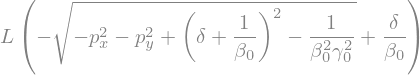

In [12]:
Hd = HamDrift6D(beta0, gamma0, L, x, px, y, py, delta)
Hd

The full Hamiltonian is very complex and when we want to restrict to the linear approximation we make use of the paraxial approximation of the  full Hmailtonian.

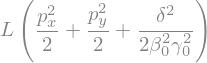

In [13]:
Hdp = HamDrift6DParaxialSecondOrder(beta0, gamma0, L, x, px, y, py, delta)
Hdp

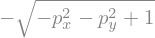

In [23]:
Hd.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1)

### Plots

Neglecting the longitudinal momentum deviation and assuming $\gamma_0 \rightarrow \infty, \beta_0 \rightarrow 1$, we can plot the full Hamiltonian

<IPython.core.display.Javascript object>


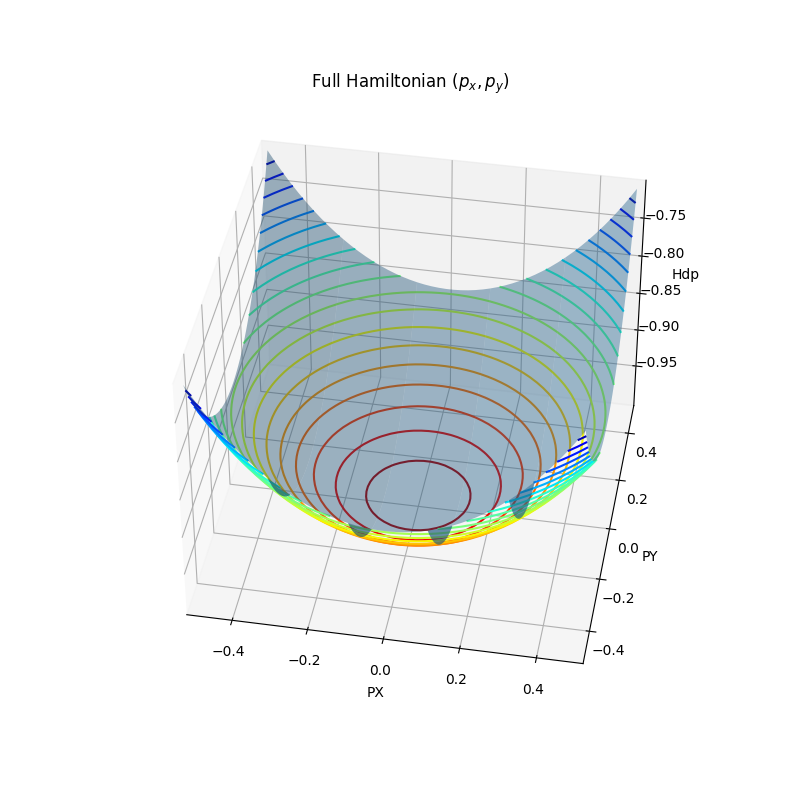

In [46]:
val = .5    # plotting range
mg  = 50   # meshgrid size
DL  = 1   # quadrupole length

PX = np.linspace(-val, val, mg)
PY = np.linspace(-val, val, mg)
PX, PY = np.meshgrid(PX, PY)
Zl = lambdify((px, py), Hd.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1),'numpy')
Z = Zl(PX,PY)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(PX, PY, Z,alpha=0.4,rstride=mg)
cset = ax.contour(PX, PY, Z,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('PX')
ax.set_xlim(-val, val)
ax.set_ylabel('PY')
ax.set_ylim(-val, val)
ax.set_zlabel('Hdp')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
#plt.savefig("/home/mti/Bilder/hamiltonian_order_0.png")
plt.title("Full Hamiltonian ($p_x,p_y$)")
plt.show()

<IPython.core.display.Javascript object>


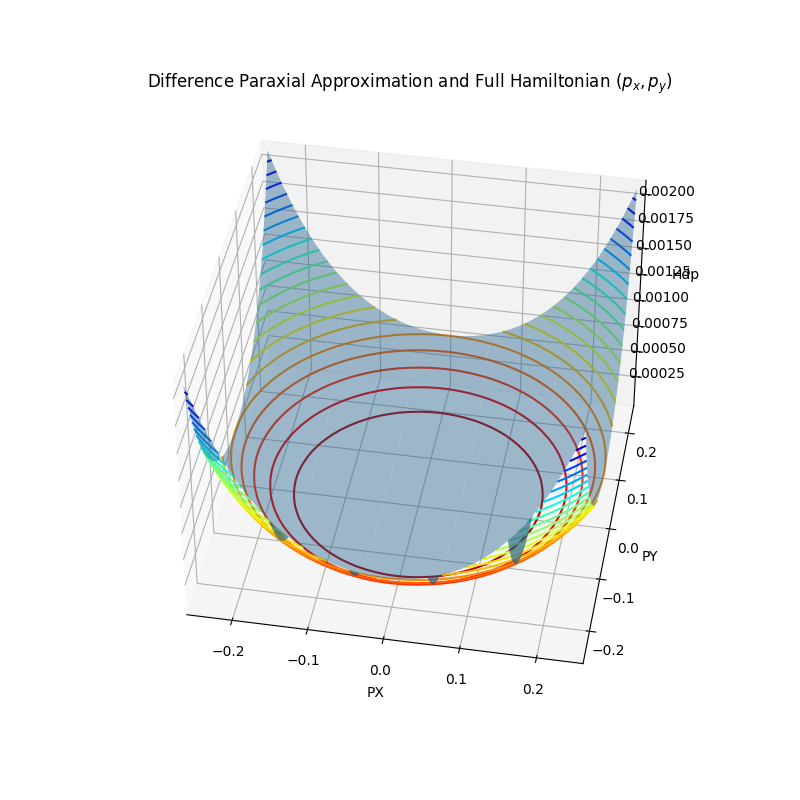

In [45]:
val = .25    # plotting range
mg  = 50   # meshgrid size
DL  = 1   # quadrupole length

PX = np.linspace(-val, val, mg)
PY = np.linspace(-val, val, mg)
PX, PY = np.meshgrid(PX, PY)
Zl = lambdify((px, py), Hd.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1) -
              Hdp.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1)+1,'numpy')
Z = Zl(PX,PY)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(PX, PY, Z,alpha=0.4,rstride=mg)
cset = ax.contour(PX, PY, Z,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('PX')
ax.set_xlim(-val, val)
ax.set_ylabel('PY')
ax.set_ylim(-val, val)
ax.set_zlabel('Hdp')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
#plt.savefig("/home/mti/Bilder/hamiltonian_order_0.png")
plt.title("Difference Paraxial Approximation and Full Hamiltonian ($p_x,p_y$)")
plt.show()

###  Equations of motion

The equations of motion are
$$ \dot{q} = \lbrace q,H\rbrace$$
$$ \dot{p} = \lbrace p,H\rbrace$$
where we used the Poisson bracket expressions.

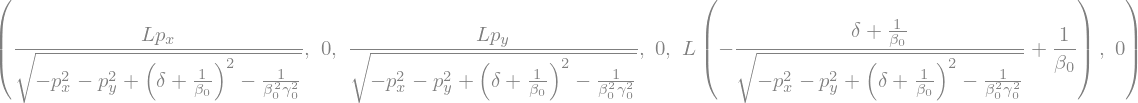

In [64]:
xdot  = Poisson(x,Hd,[x,y],[px,py])
pxdot = Poisson(px,Hd,[x,y],[px,py])
ydot  = Poisson(y,Hd,[x,y],[px,py])
pydot = Poisson(py,Hd,[x,y],[px,py])
zdot  = Poisson(z,Hd,[x,y,z],[px,py,delta])
ddot  = Poisson(delta,Hd,[x,y,z],[px,py,delta])
xdot, pxdot, ydot, pydot, zdot, ddot

For the paraxial approximation this becomes:

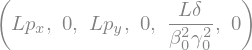

In [65]:
xdotp  = Poisson(x,Hdp,[x,y],[px,py])
pxdotp = Poisson(px,Hdp,[x,y],[px,py])
ydotp  = Poisson(y,Hdp,[x,y],[px,py])
pydotp = Poisson(py,Hdp,[x,y],[px,py])
zdotp  = Poisson(z,Hdp,[x,y,z],[px,py,delta])
ddotp  = Poisson(delta,Hdp,[x,y,z],[px,py,delta])
xdotp, pxdotp, ydotp, pydotp, zdotp, ddotp

From the last expression above it is clear that the linear transfermatrix for a drift is given by:

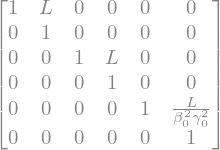

In [66]:
RsymbDrift6D(beta0,gamma0,L)

# Quadrupoles 

## Hamiltonians

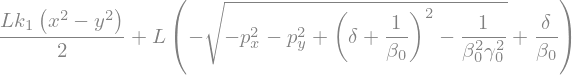

In [68]:
hamquadpar = (beta0, gamma0, L, x, px, y, py, delta, k1)
Hq = HamQuad6D(*hamquadpar)
Hq

Paraxial approximation without chromatic effects.

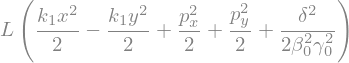

In [70]:
Hqp = HamQuad6DParaxialSecondOrder(*hamquadpar)
Hqp

Taking transverse chromatic effects into account.

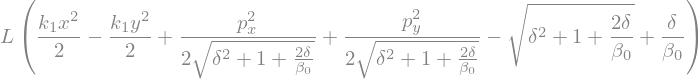

In [71]:
Hqc = HamQuad6DParaxialSecondOrderChroma(*hamquadpar)
Hqc

Thin lens approximation.

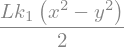

In [76]:
Hqt = HamQuad6D(*hamquadpar).args[1]
Hqt

<IPython.core.display.Javascript object>


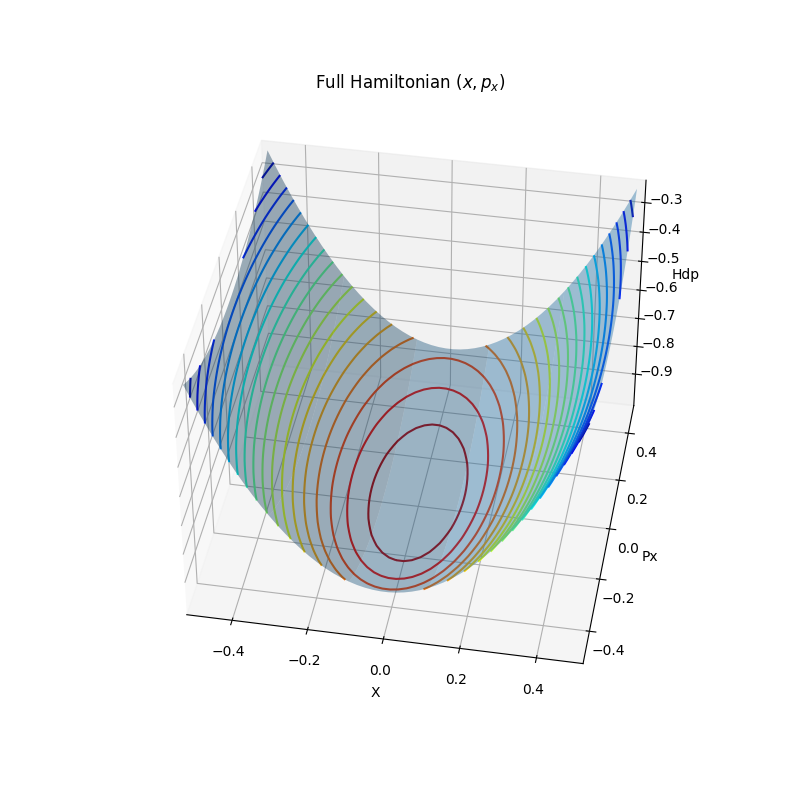

In [90]:
val = .5    # plotting range
mg  = 50   # meshgrid size
DL  = 1   # quadrupole length
xrange = (-val, val, mg)
yrange = (-val, val, mg)
X = np.linspace(*xrange)
PX = np.linspace(*yrange)
X, PX = np.meshgrid(X, PX)
Zl = lambdify((x, px), Hq.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1).subs(y,0).subs(py,0).subs(k1,5),'numpy')
Z = Zl(X,PX)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, PX, Z,alpha=0.4,rstride=mg)
cset = ax.contour(X, PX, Z,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(xrange[0],xrange[1])
ax.set_ylabel('Px')
ax.set_ylim(yrange[0], yrange[1])
ax.set_zlabel('Hdp')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
#plt.savefig("/home/mti/Bilder/hamiltonian_order_0.png")
plt.title("Full Hamiltonian ($x,p_x$)")
plt.show()

<IPython.core.display.Javascript object>


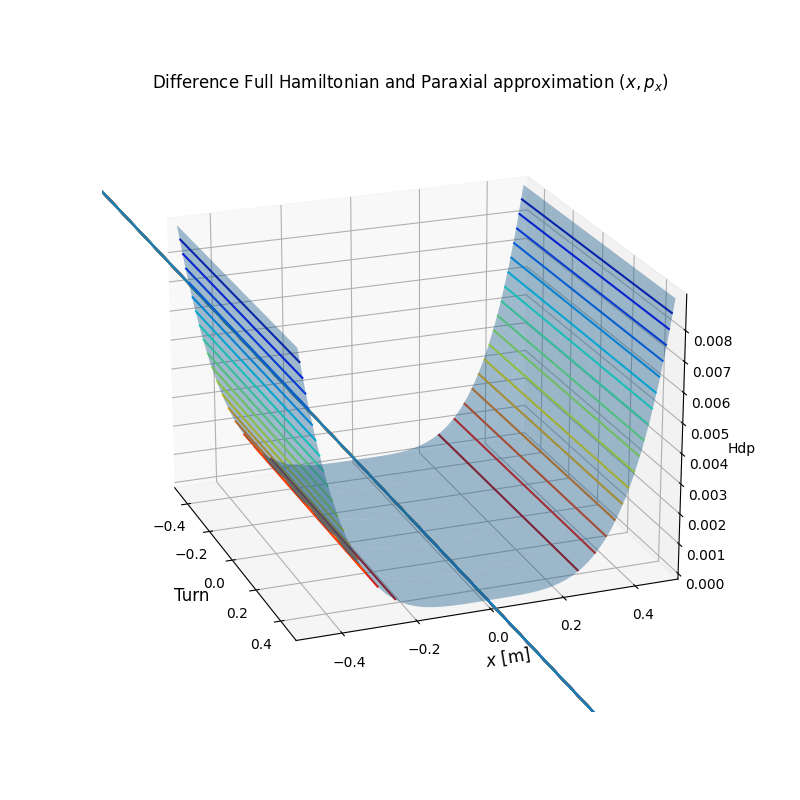

In [92]:
al = .5    # plotting range
mg  = 50   # meshgrid size
DL  = 1   # quadrupole length
xrange = (-val, val, mg)
yrange = (-val, val, mg)
X = np.linspace(*xrange)
PX = np.linspace(*yrange)
X, PX = np.meshgrid(X, PX)
Zl = lambdify((x, px), Hq.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1).subs(y,0).subs(py,0).subs(k1,5)-
              Hqc.subs(beta0*gamma0,oo).subs(L,DL).subs(delta,0).subs(beta0,1).subs(y,0).subs(py,0).subs(k1,5),'numpy')
Z = Zl(X,PX)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, PX, Z,alpha=0.4,rstride=mg)
cset = ax.contour(X, PX, Z,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(xrange[0],xrange[1])
ax.set_ylabel('Px')
ax.set_ylim(yrange[0], yrange[1])
ax.set_zlabel('Hdp')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
#plt.savefig("/home/mti/Bilder/hamiltonian_order_0.png")
plt.title("Difference Full Hamiltonian and Paraxial approximation ($x,p_x$)")
plt.show()

###  Equations of motion

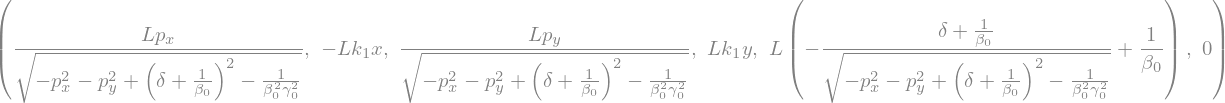

In [93]:
xdot  = Poisson(x ,Hq,[x,y],[px,py])
pxdot = Poisson(px,Hq,[x,y],[px,py])
ydot  = Poisson(y ,Hq,[x,y],[px,py])
pydot = Poisson(py,Hq,[x,y],[px,py])
zdot  = Poisson(z ,Hq,[x,y,z],[px,py,delta])
ddot  = Poisson(delta,Hq,[x,y,z],[px,py,delta])
xdot, pxdot, ydot, pydot, zdot, ddot

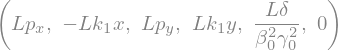

In [95]:
xdotp  = Poisson(x, Hqp,[x,y],[px,py])
pxdotp = Poisson(px,Hqp,[x,y],[px,py])
ydotp  = Poisson(y, Hqp,[x,y],[px,py])
pydotp = Poisson(py,Hqp,[x,y],[px,py])
zdotp  = Poisson(z, Hqp,[x,y,z],[px,py,delta])
ddotp  = Poisson(delta,Hdp,[x,y,z],[px,py,delta])
xdotp, pxdotp, ydotp, pydotp, zdotp, ddotp

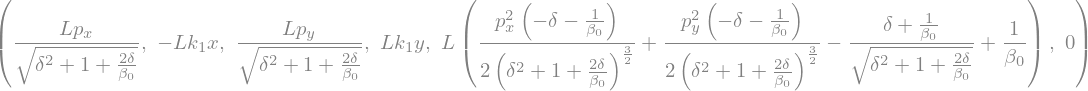

In [97]:
xdotpc  = Poisson(x, Hqc,[x,y],[px,py])
pxdotpc = Poisson(px,Hqc,[x,y],[px,py])
ydotpc  = Poisson(y, Hqc,[x,y],[px,py])
pydotpc = Poisson(py,Hqc,[x,y],[px,py])
zdotpc  = Poisson(z, Hqc,[x,y,z],[px,py,delta])
ddotpc  = Poisson(delta,Hqc,[x,y,z],[px,py,delta])
xdotpc, pxdotpc, ydotpc, pydotpc, zdotpc, ddotpc

# Matrices

In [109]:
Lfodo = 2
k1fodo = 1.5
gfodo = 1000
bfodo = np.sqrt(1-1/gfodo**2)
kfodo = 1.5
bfodo

##  Drift

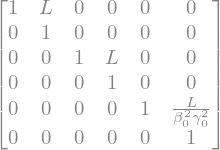

In [101]:
RsymbDrift6D(beta0, gamma0,L)

## Quads

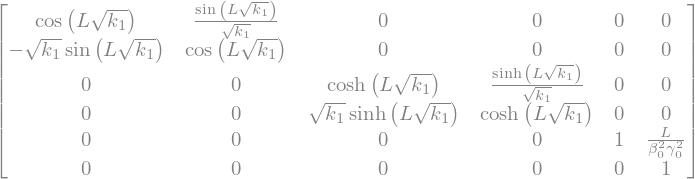

In [104]:
RsymbQuad6D(beta0,gamma0,L,k1)

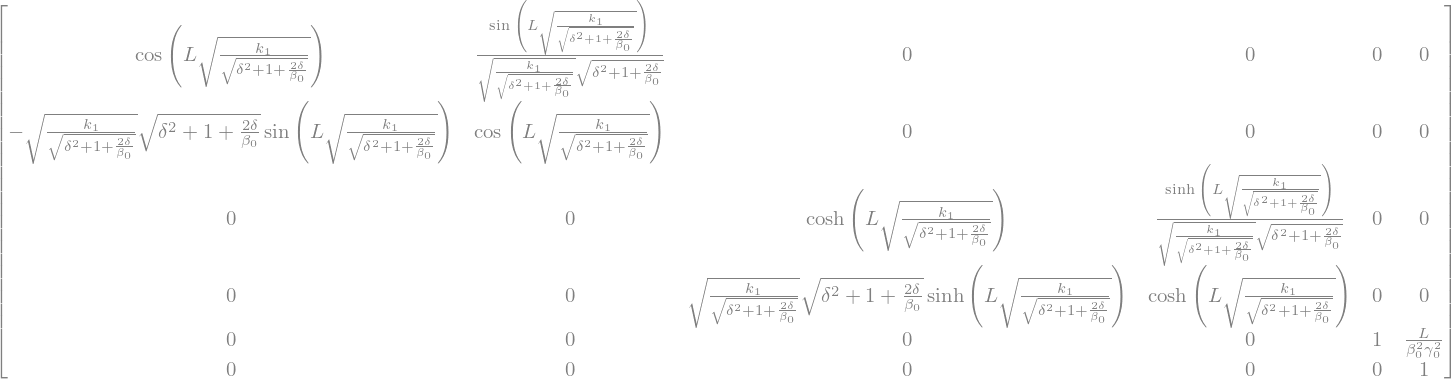

In [106]:
RsymbQuad6DChroma(beta0,gamma0,L,k1,delta)

## FODO

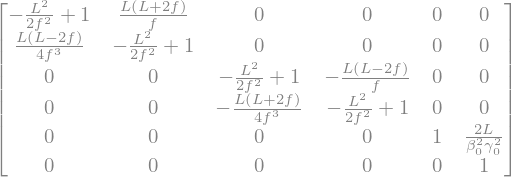

In [107]:
RsymbFODO(beta0, gamma0,L,f)

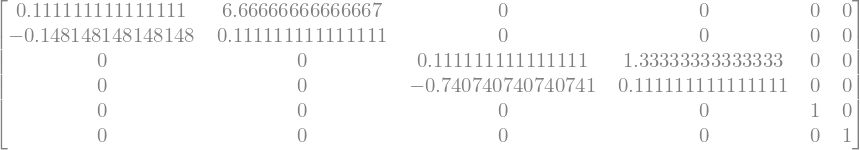

In [110]:
RsymbFODO(beta0,gamma0,L,k1).subs(beta0*gamma0,oo).subs(L,Lfodo).subs(k1,k1fodo)

# Tracking

Get the numeric tracking matrix.

In [130]:
Rfodo = RnpFODO(bfodo,gfodo,Lfodo,k1fodo)

Generate a coordinate grid to track (for details see examples in the package).

In [114]:
dim = 6
npoints = 2
coordinate_grid = GenerateNDimCoordinateGrid(dim,npoints,man_ranges={'0':np.array([1e-6,1e-5]),'1':[0]})

Shape: (6, 1, 2, 2, 2, 2, 2) - Number of paritcles: 192 


NestList is a method based on the Mathematica function that iteratively applies the function. We quickly compare two implementations for speed.

In [115]:
# functional approach
from functools import reduce
def nest_list(f, x, n, **kwargs):
    return [reduce(lambda x,y: f(x,**kwargs), range(i), x) for i in range(n+1)]

In [116]:
%%timeit
nturns = 10
Y = list(nest_list(LinMap, coordinate_grid.reshape(dim,coordinate_grid.size//6), nturns, R=Rfodo))

133 µs ± 5.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [117]:
%%timeit
nturns = 10
Y = list(nestList(LinMap, coordinate_grid.reshape(dim,coordinate_grid.size//6),nturns,R=Rfodo))

25.3 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Tracking for a  1000 Turns.

In [119]:
%time
nturns = 1000
Y = list(nestList(LinMap, coordinate_grid.reshape(6,coordinate_grid.size//6), nturns,R = Rfodo))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


## Tracking Plots

<IPython.core.display.Javascript object>


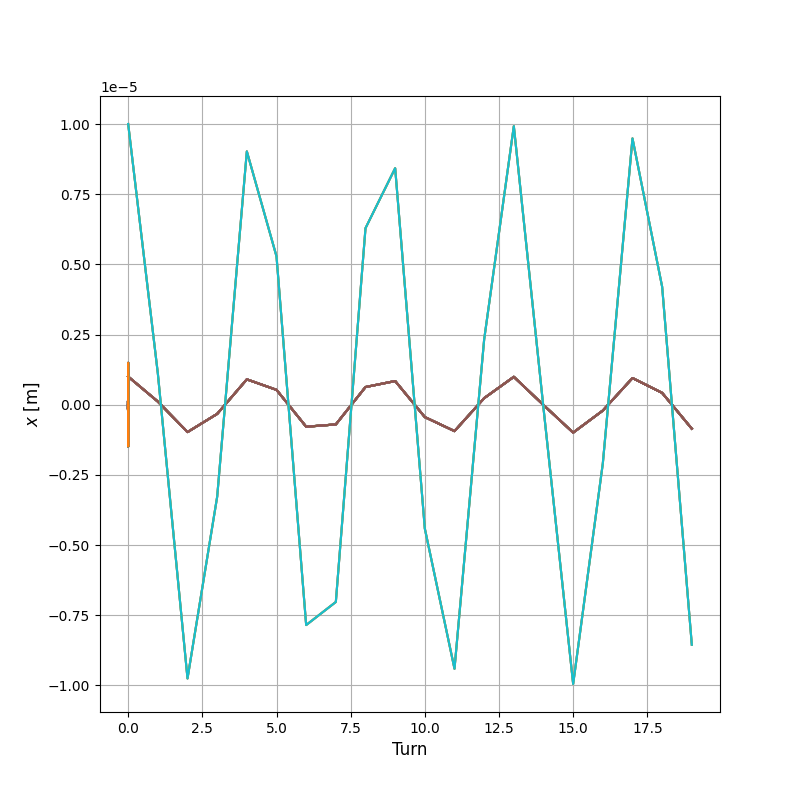

In [138]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

for i in range(20):# range(coordinate_grid.size//6):
    plotturns = range(20) #range(nturns+1)
    ax.plot(plotturns, [Y[t][0,i] for t in plotturns])

ax.set_xlabel('Turn',fontsize=12)
ax.set_ylabel(r'$x$ [m]',fontsize=12);
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


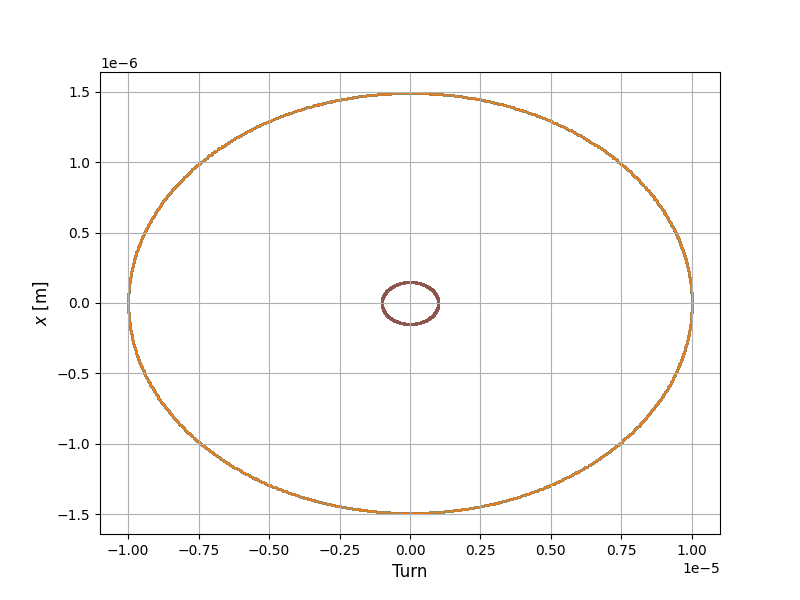

In [144]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
for i in range(coordinate_grid.size//6):
    plotturns = range(nturns+1)
    plt.scatter([Y[t][0,i] for t in plotturns], [Y[t][1,i] for t in plotturns],s=.5)
plt.grid()
plt.xlabel('Turn',fontsize=12)
plt.ylabel(r'$x$ [m]',fontsize=12);

## Symplectic? 

Take 1e6 turns to check if any detoriation in symplecticity.

<IPython.core.display.Javascript object>


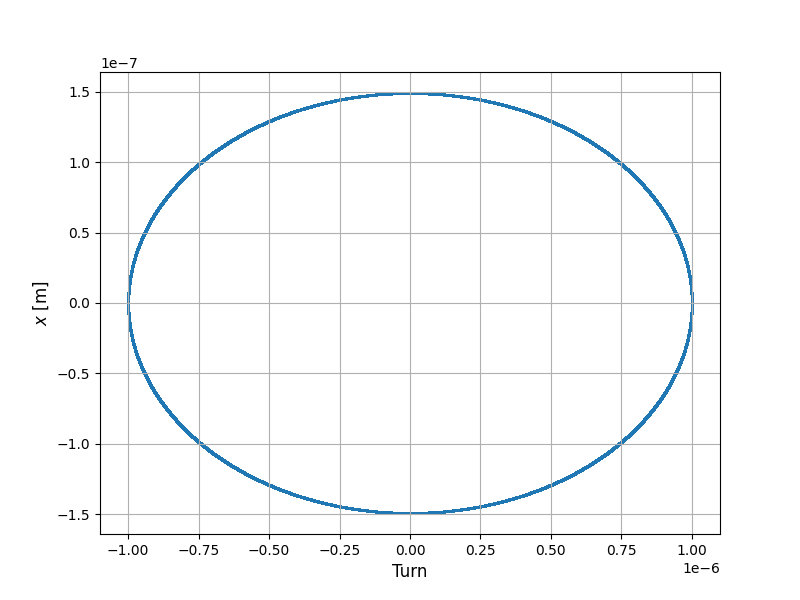

In [156]:
nturns = 1000000
Y = list(nestList(LinMap,np.array([1e-6,0,0,0,0,0]).reshape((6,1)), nturns,R = Rfodo))

fig = plt.figure(figsize=(8,6))
ax = fig.gca()

plotturns = range(nturns+1)
plt.scatter([Y[t][0,0] for t in plotturns], [Y[t][1,0] for t in plotturns],s=.5)
plt.grid()
plt.xlabel('Turn',fontsize=12)
plt.ylabel(r'$x$ [m]',fontsize=12);